In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("Temperature.csv")

In [3]:
display(df)

,YEAR,MIN_ANNUAL,MAX_ANNUAL,MIN_JAN_FEB,MAX_JAN_FEB,MIN_MAR_MAY,MAX_MAR_MAY,MIN_JUN_SEP,MAX_JUN_SEP,MIN_OCT_DEC,MAX_OCT_DEC
0,1901,20.55,30.29,15.11,25.10,21.99,33.29,24.32,32.00,17.73,28.48
1,1902,20.45,30.40,14.61,27.14,22.43,33.49,24.24,31.73,17.31,27.71
2,1903,20.13,29.88,14.30,25.68,21.33,32.72,24.37,31.64,17.16,27.51
3,1904,20.06,29.80,13.99,25.53,21.80,32.67,23.87,31.27,17.29,27.83
4,1905,20.01,29.66,12.98,23.73,21.00,31.75,24.47,31.93,17.76,28.49
...,...,...,...,...,...,...,...,...,...,...,...
116,2017,20.76,31.31,15.08,27.67,22.29,34.12,24.41,32.38,18.17,29.51
117,2018,20.57,31.22,14.76,27.72,22.21,34.12,24.34,32.22,17.76,29.35
118,2019,20.83,30.88,14.63,26.79,22.13,33.88,24.66,32.54,18.58,28.40
119,2020,20.76,30.81,15.06,26.51,21.96,33.20,24.60,32.31,18.25,29.26


In [4]:
df.set_index('YEAR', inplace=True)
df.index = pd.to_datetime(df.index, format="%Y")

In [5]:
df.index

DatetimeIndex(['1901-01-01', '1902-01-01', '1903-01-01', '1904-01-01',
               '1905-01-01', '1906-01-01', '1907-01-01', '1908-01-01',
               '1909-01-01', '1910-01-01',
               ...
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01'],
              dtype='datetime64[ns]', name='YEAR', length=121, freq=None)

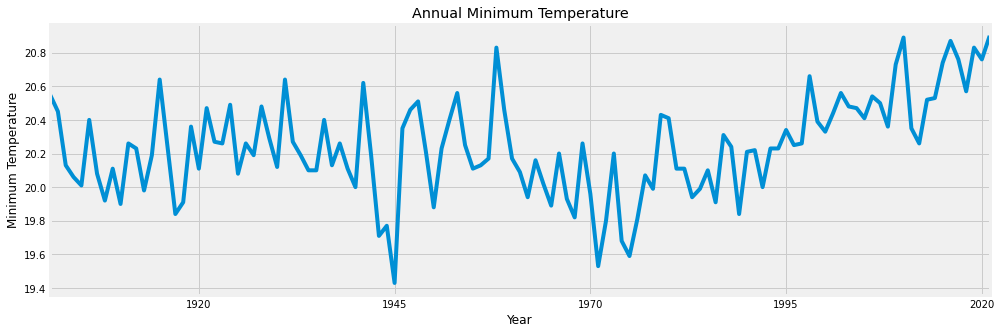

In [6]:
df['MIN_ANNUAL'].plot(figsize = (15,5))
plt.title('Annual Minimum Temperature')
plt.xlabel('Year')
plt.ylabel('Minimum Temperature')
plt.show()

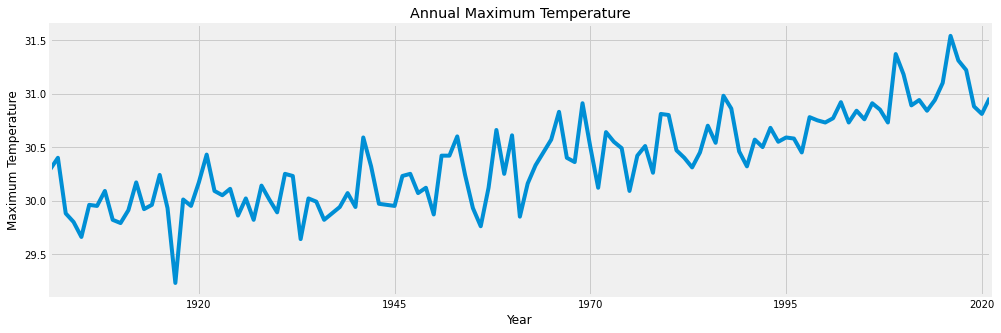

In [7]:
df['MAX_ANNUAL'].plot(figsize = (15,5))
plt.title('Annual Maximum Temperature')
plt.xlabel('Year')
plt.ylabel('Maximum Temperature')
plt.show()

<Axes: >

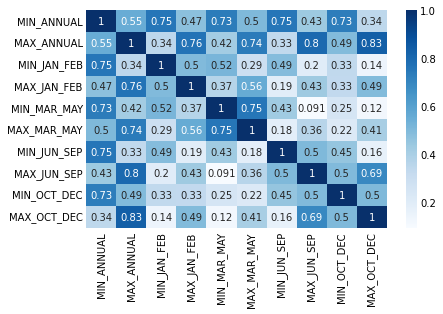

In [8]:
relation = df.corr()
sns.heatmap(relation, cmap='Blues', annot=True)

In [9]:
minimum = df[['MIN_ANNUAL']]
train = minimum.loc[minimum.index < '2010-01-01']
test = minimum.loc[minimum.index >= '2010-01-01']

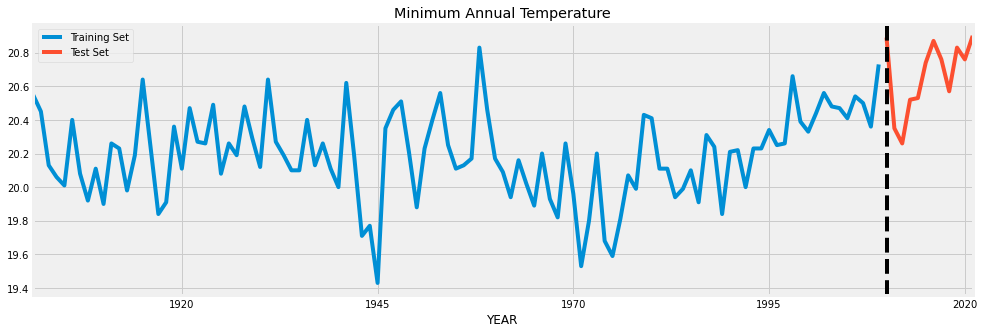

In [10]:
fig, ax1 = plt.subplots(figsize=(15, 5))
train['MIN_ANNUAL'].plot(ax=ax1, label='Training Set', title='Minimum Annual Temperature')
test['MIN_ANNUAL'].plot(ax=ax1, label='Test Set')
ax1.axvline('2010-01-01', color='black', ls='--')
ax1.legend(['Training Set', 'Test Set'])
plt.show()

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

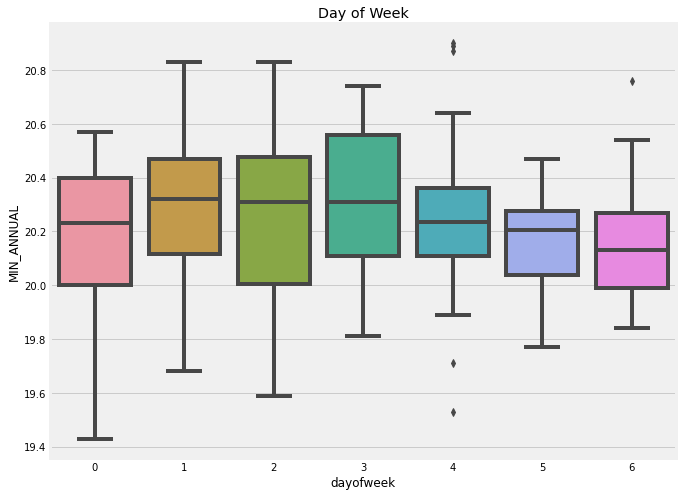

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='MIN_ANNUAL')
ax.set_title('Day of Week')
plt.show()

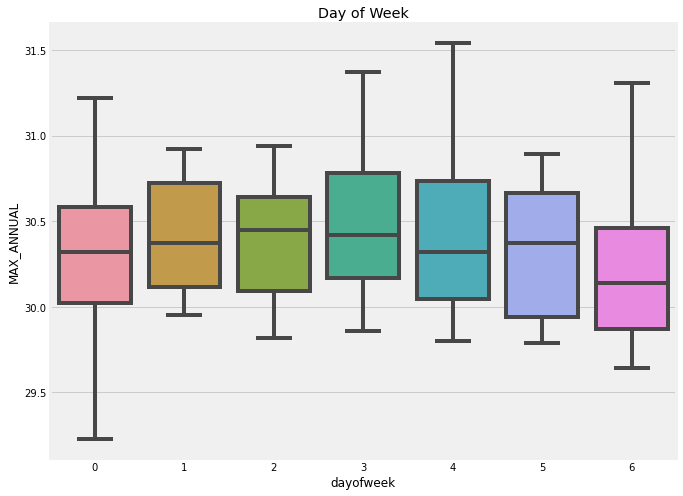

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='MAX_ANNUAL')
ax.set_title('Day of Week')
plt.show()

In [14]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'MIN_ANNUAL'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [15]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=50)

[10:37:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:19.49798	validation_1-rmse:19.97094
[50]	validation_0-rmse:11.85247	validation_1-rmse:12.32498
[100]	validation_0-rmse:7.20676	validation_1-rmse:7.67848
[150]	validation_0-rmse:4.38504	validation_1-rmse:4.85536
[200]	validation_0-rmse:2.67313	validation_1-rmse:3.14091
[250]	validation_0-rmse:1.63770	validation_1-rmse:2.10080
[300]	validation_0-rmse:1.01646	validation_1-rmse:1.47096
[350]	validation_0-rmse:0.64852	validation_1-rmse:1.02244
[400]	validation_0-rmse:0.43265	validation_1-rmse:0.73139
[450]	validation_0-rmse:0.31003	validation_1-rmse:0.55796
[500]	validation_0-rmse:0.24248	validation_1-rmse:0.45564
[550]	validation_0-rmse:0.20557	validation_1-rmse:0.39487
[600]	validation_0-rmse:0.18638	validation_1-rmse:0.35822
[650]	validati

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

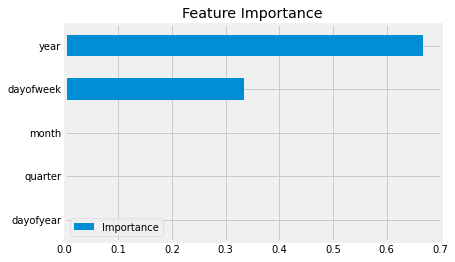

In [16]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['Importance'])
fi.sort_values('Importance').plot(kind='barh', title='Feature Importance')
plt.show()

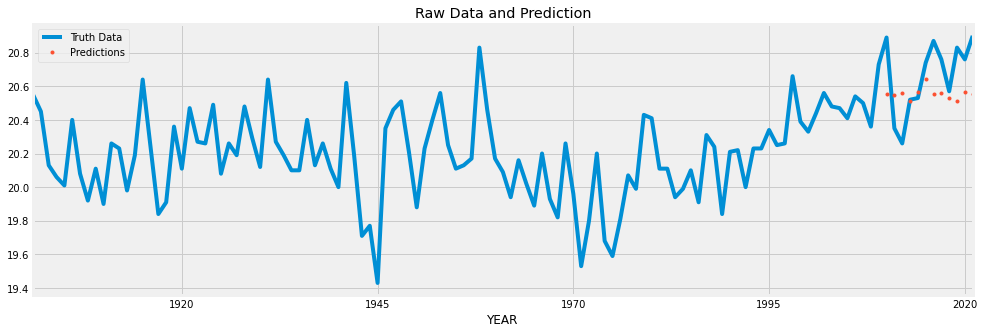

In [17]:
test['Prediction'] = reg.predict(X_test)
df = df.merge(test[['Prediction']], how='left', left_index=True, right_index=True)
ax = df[['MIN_ANNUAL']].plot(figsize=(15, 5))
df['Prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [18]:
score = np.sqrt(mean_squared_error(test['MIN_ANNUAL'], test['Prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.23


In [19]:
test['error'] = np.abs(test[TARGET] - test['Prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2021-01-01    0.343607
2010-01-01    0.333607
2019-01-01    0.314810
2016-01-01    0.313607
2012-01-01    0.301628
2017-01-01    0.198372
2011-01-01    0.195414
2020-01-01    0.194011
2015-01-01    0.096354
2018-01-01    0.040774
Name: error, dtype: float64